In [40]:
from matplotlib import pyplot as plt
import os
import numpy as np
import json
import pandas as pd

file_dir = "/data03/sunyi/time_constrained_cot/outputs/2_6"
model_list = [
    "Qwen/Qwen2.5-32B-Instruct",
    "Qwen/Qwen2.5-14B-Instruct", 
    "Qwen/Qwen2.5-7B-Instruct", 
    "Qwen/Qwen2.5-1.5B-Instruct",

    "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B",
]
o1_like_models = [
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B"
]

no_o1_models = [
    "Qwen/Qwen2.5-32B-Instruct", 
    "Qwen/Qwen2.5-14B-Instruct", 
    "Qwen/Qwen2.5-7B-Instruct", 
    "Qwen/Qwen2.5-1.5B-Instruct",
]

model_list = o1_like_models + no_o1_models

PROMP_LIST = [ "-sbs"]


In [41]:
MODEL_SERIES_MAP = {
    "NovaSky-AI/Sky-T1-32B-Preview": "qwen",
    "Qwen/QwQ-32B-Preview": "qwen",
    "Qwen/Qwen2.5-32B-Instruct": "qwen",
    "Qwen/Qwen2.5-14B-Instruct": "qwen",
    "Qwen/Qwen2.5-7B-Instruct": "qwen",
    "Qwen/Qwen2.5-3B-Instruct": "qwen",
    "Qwen/Qwen2.5-1.5B-Instruct": "qwen",
    "Qwen/Qwen2.5-Math-1.5B-Instruct": "qwen-math",
    "Qwen/Qwen2.5-Math-7B-Instruct": "qwen-math",
    
    "google/gemma-2-2b-it": "gemma",
    "google/gemma-2-9b-it": "gemma",
    "google/gemma-2-27b-it": "gemma",
    
    "mistralai/Mathstral-7B-v0.1": "mistral",
    "mistralai/Ministral-8B-Instruct-2410": "mistral",
    "mistralai/Mistral-Nemo-Instruct-2407": "mistral",
    "mistralai/Mistral-Small-Instruct-2409": "mistral",
    
    "microsoft/phi-4": "phi4",
    "microsoft/Phi-3-medium-128k-instruct": "phi3medium",
    "microsoft/Phi-3-small-128k-instruct": "phi3small",
    "microsoft/Phi-3.5-mini-instruct": "phi3mini",
    "microsoft/Phi-3-mini-128k-instruct": "phi3mini",
    
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B": "deepseek-r1-distill",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B": "deepseek-r1-distill",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B": "deepseek-r1-distill",
    "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B": "deepseek-r1-distill",
    "deepseek-ai/DeepSeek-R1-Distill-Llama-8B": "deepseek-r1-distill",
    
    "meta-llama/Llama-3.2-3B-Instruct": "llama",
    "meta-llama/Llama-3.2-1B-Instruct": "llama",
    "meta-llama/Llama-3.1-8B-Instruct": "llama"
}


MODEL_SERIES_PROMPT_TYPE_MAP = {
    "qwen": ["qwen" + prompt for prompt in PROMP_LIST],
    "qwen-math": ["qwen-math" + prompt for prompt in PROMP_LIST],
    "mistral": ["mistral"+prompt for prompt in PROMP_LIST],
    "gemma": ["gemma"+prompt for prompt in PROMP_LIST],
    "phi3mini": ["phi3mini"+prompt for prompt in PROMP_LIST],
    "phi3small": ["phi3small"+prompt for prompt in PROMP_LIST],
    "phi3medium": ["phi3medium"+prompt for prompt in PROMP_LIST],
    "phi4": ["phi4"+prompt for prompt in PROMP_LIST],
    "deepseek-r1-distill": ["deepseek-r1-distill"+prompt for prompt in PROMP_LIST],
    "llama": ["llama"+prompt for prompt in PROMP_LIST]
}

In [42]:
def gen_budget_list(budget, data_name, model):
    if budget == -1:
        return [-1]
    elif budget == 1:
        o1_like_models = [
            "Qwen/QwQ-32B-Preview", 
            "Skywork/Skywork-o1-Open-Llama-3.1-8B", 
            "PowerInfer/SmallThinker-3B-Preview",
            "NovaSky-AI/Sky-T1-32B-Preview", 
            "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
            "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
            "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B",
            "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B",
            "deepseek-ai/DeepSeek-R1-Distill-Llama-8B"
        ]
        if model in o1_like_models: # maybe should extend to longer sequence
            if data_name in ["gsm8k"]:
                budget_list = []
                for i in range(25, 300, 25):
                    budget_list.append(i)
                for i in range(300, 600, 50):
                    budget_list.append(i)
                for i in range(600, 1501, 100):
                    budget_list.append(i)
            elif data_name in ["math", "math500", "mmlu_stem", "acpbench"]:
                budget_list = []
                for i in range(25, 600, 25):
                    budget_list.append(i)
                for i in range(600, 3601, 100):
                    budget_list.append(i)
        else:    
            if data_name in ["gsm8k"]:
                budget_list = []
                for i in range(25, 300, 25):
                    budget_list.append(i)
                for i in range(300, 601, 50):
                    budget_list.append(i)
            elif data_name in ["math", "math500", "mmlu_stem", "acpbench"]:
                budget_list = []
                for i in range(25, 300, 25):
                    budget_list.append(i)
                for i in range(300, 600, 50):
                    budget_list.append(i)
                for i in range(600, 1201, 100):
                    budget_list.append(i)
        
        return budget_list

In [43]:
dataset = "mmlu_stem"
something = "_-1_seed0_t0.0_s0_e-1"

In [44]:
model_acc_dicts = {}
prompt_acc_dicts = {}

for model in model_list:
    model_acc_dict = {}
    budget_list = gen_budget_list(1, dataset, model)
    model_prompt_list = MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]
    for prompt_type in model_prompt_list:
        acc_list = []
        for budget in budget_list:
            file_name = "test_" + prompt_type + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path = os.path.join(file_dir, model, prompt_type, dataset, file_name)
            with open(file_path, "r") as f:
                acc_list.append(json.load(f)["acc"])
        model_acc_dict[prompt_type] = acc_list
    model_acc_dicts[model] = model_acc_dict

display(model_acc_dicts)

{'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B': {'deepseek-r1-distill-sbs': [27.9,
   27.8,
   28.4,
   30.5,
   30.6,
   33.2,
   34.2,
   36.1,
   37.3,
   37.2,
   38.8,
   39.9,
   40.1,
   40.9,
   41.9,
   43.7,
   44.3,
   45.5,
   46.5,
   47.2,
   48.4,
   47.8,
   48.3,
   49.6,
   50.6,
   52.8,
   53.7,
   54.4,
   55.2,
   56.1,
   56.6,
   56.4,
   56.8,
   57.1,
   57.1,
   57.2,
   57.4,
   57.3,
   57.7,
   57.3,
   57.6,
   57.2,
   57.5,
   57.7,
   57.3,
   57.5,
   57.7,
   57.8,
   57.7,
   57.7,
   58.0,
   58.5,
   58.3,
   58.1]},
 'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B': {'deepseek-r1-distill-sbs': [35.2,
   37.6,
   37.1,
   39.1,
   40.0,
   41.6,
   41.1,
   41.1,
   40.6,
   40.8,
   41.0,
   41.9,
   43.1,
   44.5,
   45.0,
   46.0,
   48.3,
   49.4,
   50.8,
   52.5,
   53.3,
   55.1,
   56.0,
   55.7,
   57.9,
   59.4,
   61.2,
   61.3,
   62.1,
   63.0,
   63.7,
   64.3,
   64.6,
   64.4,
   64.8,
   65.1,
   65.3,
   65.4,
   65.3,
   65.9,
   65.7,
 

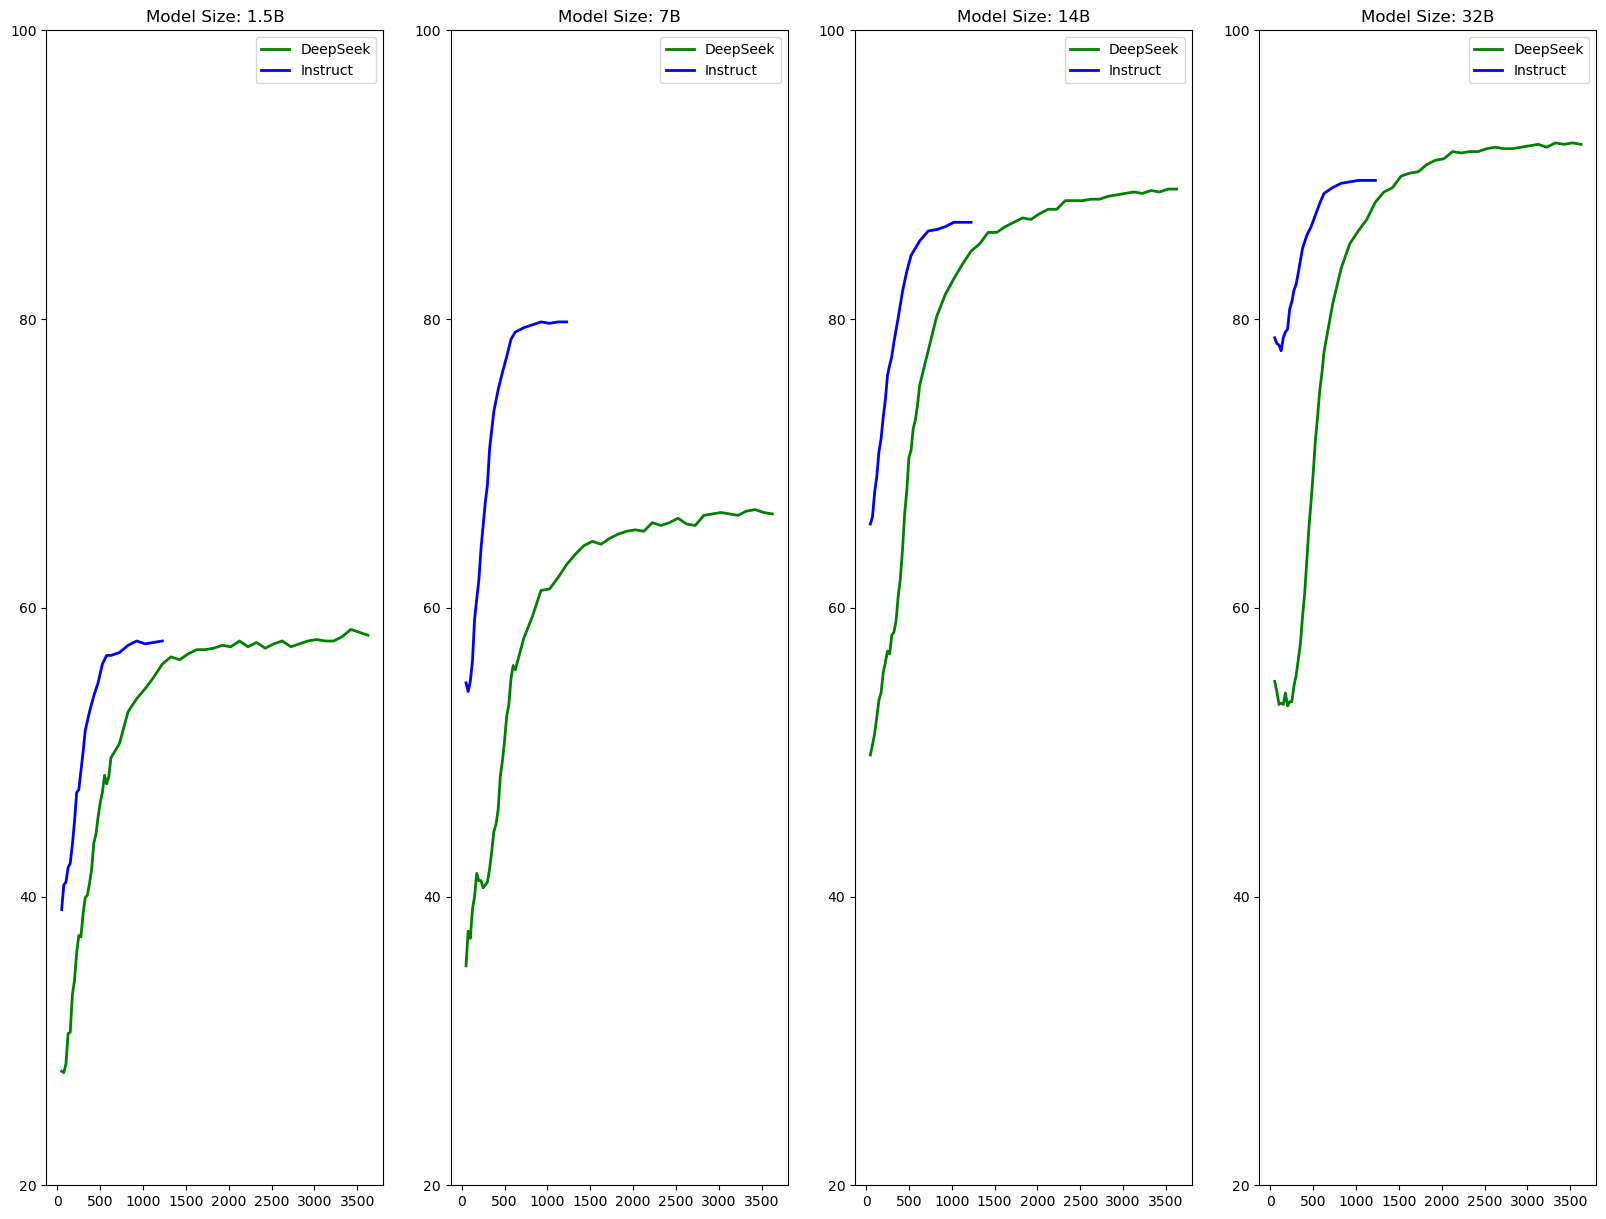

In [45]:
o1_like_models = {
    "1.5B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    "7B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
    "14B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B",
    "32B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B"
}

no_o1_models = {
    "32B": "Qwen/Qwen2.5-32B-Instruct", 
    "14B": "Qwen/Qwen2.5-14B-Instruct", 
    "7B": "Qwen/Qwen2.5-7B-Instruct", 
    "1.5B": "Qwen/Qwen2.5-1.5B-Instruct",
}

o1_budget_list = gen_budget_list(1, dataset, o1_like_models["1.5B"])
no_o1_budget_list = gen_budget_list(1, dataset, no_o1_models["1.5B"])

models = ["1.5B", "7B", "14B", "32B"]

# 绘制1行4列的图
fig, axs = plt.subplots(1, 4, figsize=(20, 15))

for i, model in enumerate(models):
    axs[i].plot([budget + 25 for budget in o1_budget_list], model_acc_dicts[o1_like_models[model]][MODEL_SERIES_MAP[o1_like_models[model]] + "-sbs"], label="DeepSeek", color="green", linewidth=2)
    axs[i].plot([budget + 25 for budget in no_o1_budget_list], model_acc_dicts[no_o1_models[model]][MODEL_SERIES_MAP[no_o1_models[model]] + "-sbs"], label="Instruct", color="blue", linewidth=2)
    axs[i].set_yticks(range(20, 101, 20)) 
    axs[i].set_title(f"Model Size: {model}")
    axs[i].legend()


In [46]:
dataset = "acpbench"
something = "_-1_seed0_t0.0_s0_e-1"

In [47]:
model_acc_dicts = {}
prompt_acc_dicts = {}

for model in model_list:
    model_acc_dict = {}
    budget_list = gen_budget_list(1, dataset, model)
    model_prompt_list = MODEL_SERIES_PROMPT_TYPE_MAP[MODEL_SERIES_MAP[model]]
    for prompt_type in model_prompt_list:
        acc_list = []
        for budget in budget_list:
            file_name = "test_" + prompt_type + something + "_b" + str(int(budget)) + "_metrics.json"
            file_path = os.path.join(file_dir, model, prompt_type, dataset, file_name)
            with open(file_path, "r") as f:
                acc_list.append(json.load(f)["acc"])
        model_acc_dict[prompt_type] = acc_list
    model_acc_dicts[model] = model_acc_dict

display(model_acc_dicts)

{'deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B': {'deepseek-r1-distill-sbs': [19.4,
   14.2,
   13.1,
   13.4,
   13.7,
   14.0,
   15.8,
   17.6,
   18.4,
   19.9,
   21.2,
   20.0,
   20.6,
   22.0,
   23.1,
   23.2,
   22.0,
   24.2,
   25.4,
   26.0,
   24.9,
   28.0,
   28.2,
   28.4,
   30.1,
   30.2,
   32.2,
   32.6,
   31.8,
   31.4,
   32.7,
   31.3,
   33.4,
   33.2,
   32.1,
   32.2,
   31.9,
   31.8,
   31.9,
   31.3,
   30.7,
   32.2,
   31.4,
   30.8,
   30.8,
   30.0,
   30.0,
   30.0,
   29.8,
   31.2,
   30.6,
   32.1,
   32.2,
   31.4]},
 'deepseek-ai/DeepSeek-R1-Distill-Qwen-7B': {'deepseek-r1-distill-sbs': [36.1,
   36.3,
   35.9,
   35.2,
   34.3,
   36.0,
   35.8,
   33.9,
   33.2,
   32.8,
   30.0,
   31.4,
   29.8,
   30.8,
   31.1,
   31.2,
   31.8,
   31.8,
   31.9,
   33.7,
   36.2,
   35.8,
   34.9,
   36.9,
   39.8,
   37.0,
   37.6,
   41.2,
   44.8,
   48.0,
   48.0,
   48.7,
   49.2,
   49.0,
   49.7,
   49.9,
   51.4,
   51.0,
   50.0,
   52.8,
   51.6,
 

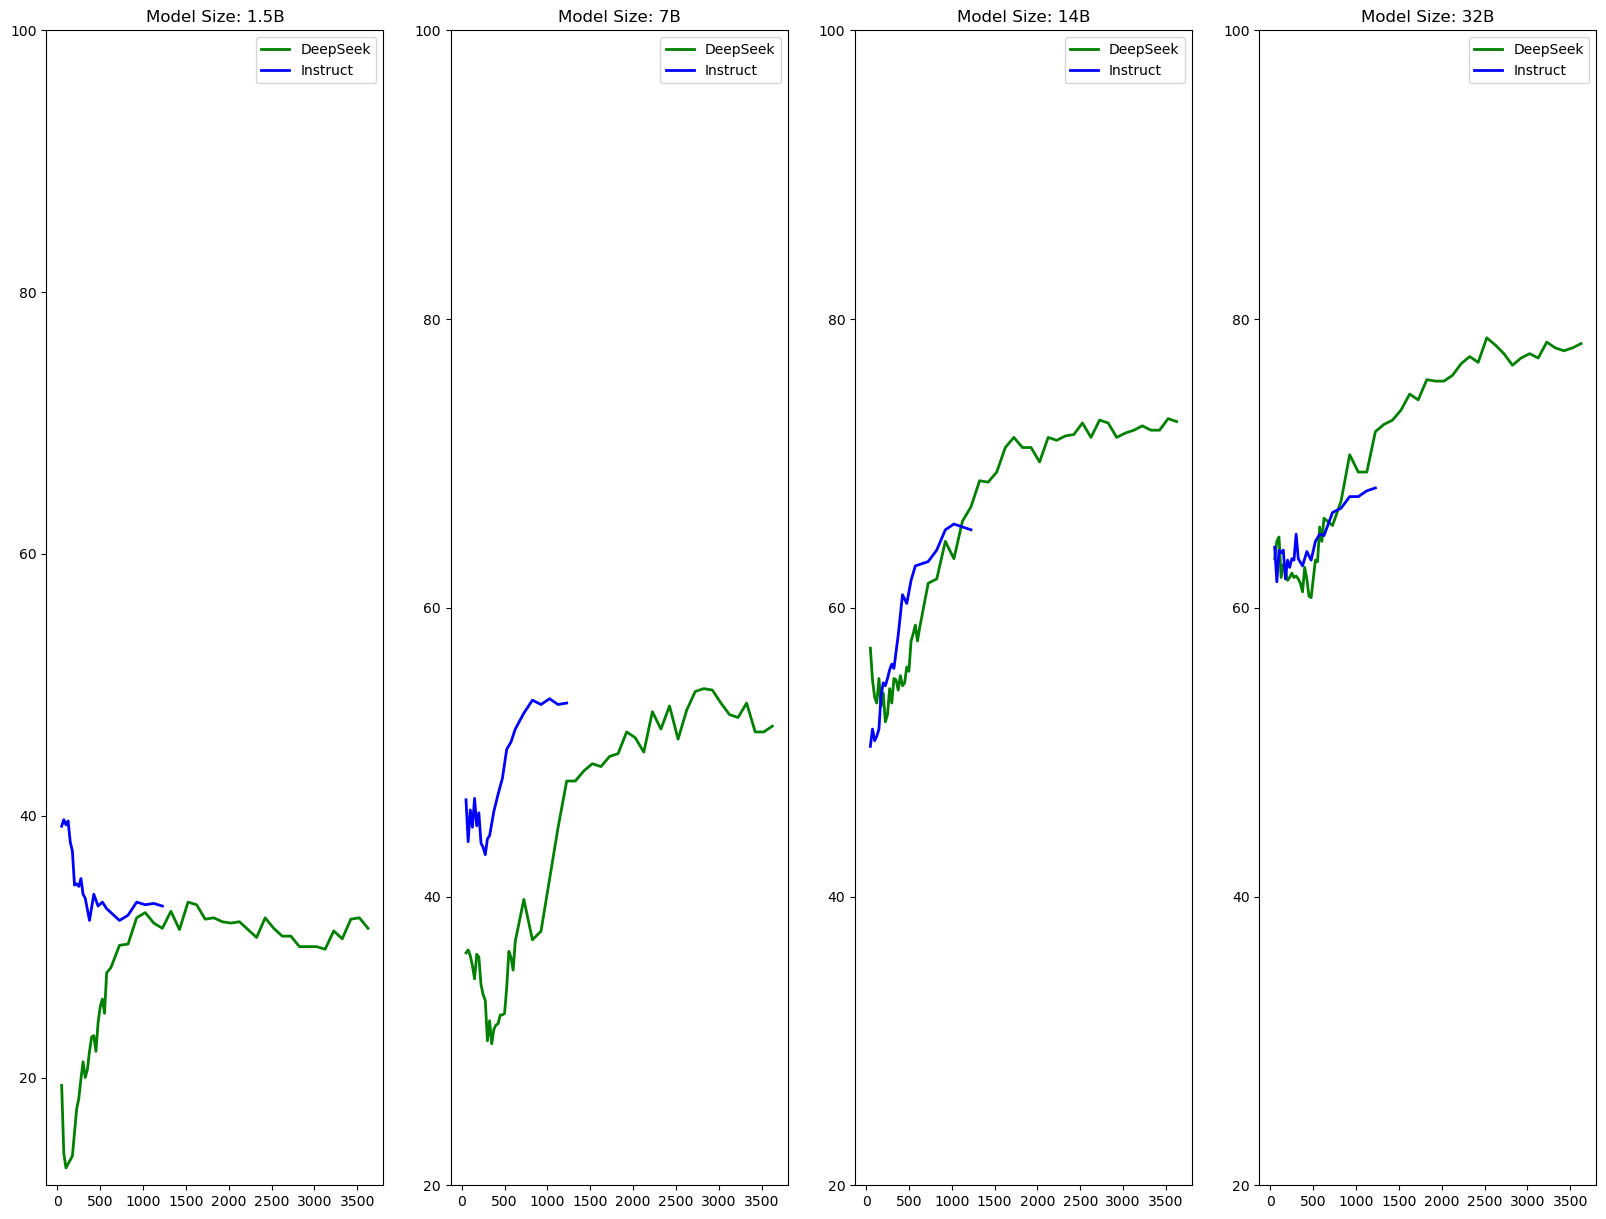

In [48]:
o1_like_models = {
    "1.5B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-1.5B",
    "7B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B",
    "14B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-14B",
    "32B": "deepseek-ai/DeepSeek-R1-Distill-Qwen-32B"
}

no_o1_models = {
    "32B": "Qwen/Qwen2.5-32B-Instruct", 
    "14B": "Qwen/Qwen2.5-14B-Instruct", 
    "7B": "Qwen/Qwen2.5-7B-Instruct", 
    "1.5B": "Qwen/Qwen2.5-1.5B-Instruct",
}

o1_budget_list = gen_budget_list(1, dataset, o1_like_models["1.5B"])
no_o1_budget_list = gen_budget_list(1, dataset, no_o1_models["1.5B"])

models = ["1.5B", "7B", "14B", "32B"]

# 绘制1行4列的图
fig, axs = plt.subplots(1, 4, figsize=(20, 15))

for i, model in enumerate(models):
    axs[i].plot([budget + 25 for budget in o1_budget_list], model_acc_dicts[o1_like_models[model]][MODEL_SERIES_MAP[o1_like_models[model]] + "-sbs"], label="DeepSeek", color="green", linewidth=2)
    axs[i].plot([budget + 25 for budget in no_o1_budget_list], model_acc_dicts[no_o1_models[model]][MODEL_SERIES_MAP[no_o1_models[model]] + "-sbs"], label="Instruct", color="blue", linewidth=2)
    axs[i].set_yticks(range(20, 101, 20)) 
    axs[i].set_title(f"Model Size: {model}")
    axs[i].legend()
